In [2]:
from pathlib import Path

from paraphone.tasks.phonemize import PhonemizedWordsCSV
from paraphone.tasks.synth import GoogleSpeakSynthesizer, VOICES

synth = GoogleSpeakSynthesizer("fr", VOICES["fr"][0],
                               Path("../morphologicalstudy-1224861510d4.json"))

words = {"jeune", "jeuner", "os", "osseux", "oeuf", "euphémisme", "bonne",
         "beaune", "tomme", "tome", "taume", "comme", "côme", "gomme",
         "somme", "chaume", "nonne", "môme", "bol", "tôle", "col", "folle",
         "vol", "geole", "molle", "grolle"}
pho_word_csv = PhonemizedWordsCSV(Path("../workspaces/large_fr/phonemized/all.csv"))
pho_dict = pho_word_csv.to_dict()
tested_words = {
    word: " ".join(pho_dict[word]) for word in words if word in pho_dict
}
# TODO:

In [6]:
pho_ssml_template = """
<speak>
{word}
<break time="1s"/>
<phoneme alphabet="ipa" ph="{phonemes}"></phoneme>
</speak>
"""

In [6]:
OUTPUT_DIR = Path("/tmp/synth_tests/")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
import nest_asyncio

nest_asyncio.apply()

In [9]:
from asyncio import get_event_loop

loop = get_event_loop()
for word, phonemes in tested_words.items():
    task = synth.synth_ssml(pho_ssml_template.format(word=word, phonemes=phonemes.replace(" ", "")))
    audio_output = loop.run_until_complete(task)
    with open(OUTPUT_DIR / Path(f"{word}.ogg"), "wb") as audio_file:
        audio_file.write(audio_output)

In [16]:
from asyncio import get_event_loop

pho_ssml_template = """
<speak>
<phoneme alphabet="ipa" ph="{phonemes}"></phoneme>
</speak>
"""

text_ssml_template = """
<speak>
{word}
</speak>
"""

tested_words = {"chien": "ʃ j ɛ̃",
                "lapin": "l a p ɛ̃",
                "escargot": "ɛ s k a ʁ ɡ o",
                "pomme": "p ɔ m",
                "poire": "p w a ʁ",
                "devenir": "d ə v ə n i ʁ"}

loop = get_event_loop()
for word, phonemes in tested_words.items():
    task_pho = synth.synth_ssml(pho_ssml_template.format(word=word, phonemes=phonemes.replace(" ", "")))
    audio_output = loop.run_until_complete(task_pho)
    with open(OUTPUT_DIR / Path(f"{word}_pho.ogg"), "wb") as audio_file:
        audio_file.write(audio_output)

    #task_text = synth.synth_ssml(text_ssml_template.format(word=word))
    task_text = synth.synth_text(word)
    audio_output = loop.run_until_complete(task_text)
    with open(OUTPUT_DIR / Path(f"{word}_txt.ogg"), "wb") as audio_file:
        audio_file.write(audio_output)


In [17]:
from pydub import AudioSegment
import numpy as np

for word in tested_words:
    array_text = np.array(AudioSegment.from_ogg(OUTPUT_DIR / Path(f"{word}_txt.ogg")).get_array_of_samples())
    array_pho = np.array(AudioSegment.from_ogg(OUTPUT_DIR / Path(f"{word}_pho.ogg")).get_array_of_samples())
    min_len = min(len(array_pho), len(array_text))
    print(f"{word}: ", np.abs(array_text[:min_len] - array_pho[:min_len]).sum())

chien:  3927781738605
lapin:  5480830304602
escargot:  5812454365175
pomme:  4941393474969
poire:  4395417474030
devenir:  7814065350023


In [20]:
from paraphone.tasks.filters.base import CandidatesPairCSV
from pathlib import Path
from dataclasses import dataclass
from tqdm import tqdm
from audioread import audio_open
from audioread.gstdec import GstAudioFile

@dataclass
class Durations:
    text: float
    phonetic_true: float
    phonetic_fake: float

def get_dur(audio_path: Path) -> float:
    with audio_open(audio_path, backends=[GstAudioFile]) as audio_file:
        return audio_file.duration

AUDIO_SYNTH_DIR = Path("../workspaces/large_fr/synth/audio/")
PHONETIC_SYNTH_DIR = AUDIO_SYNTH_DIR / Path("phonetic")
TEXT_SYNTH_DIR = AUDIO_SYNTH_DIR / Path("text")
corpus_64_pairs = CandidatesPairCSV(Path("../workspaces/large_fr/corpora/wuggy_pairs/corpus_64.csv"))

all_voices = {p.name for p in PHONETIC_SYNTH_DIR.iterdir()}
synthed_audio_durations_nocuts = {}
for voice_id in all_voices:
    durations_dict = {}
    for word, phonetic, fake_phonetic in tqdm(corpus_64_pairs, total=corpus_64_pairs.lines_count):
        phonetic = phonetic.replace(" ", "_")
        fake_phonetic = fake_phonetic.replace(" ", "_")
        durations_dict[word]= Durations(
            text=get_dur(TEXT_SYNTH_DIR / Path(voice_id) / Path(f"{word}.ogg")),
            phonetic_true=get_dur(PHONETIC_SYNTH_DIR / Path(voice_id) / Path(f"{phonetic}.ogg")),
            phonetic_fake=get_dur(PHONETIC_SYNTH_DIR / Path(voice_id) / Path(f"{fake_phonetic}.ogg"))
        )
    synthed_audio_durations_nocuts[voice_id] = durations_dict

 64%|██████▎   | 2068/3245 [00:52<00:18, 63.34it/s]
(python:119906): GStreamer-WARNING **: 14:31:49.997: gstpad.c:5204:store_sticky_event:<src_0:proxypad276159> Sticky event misordering, got 'caps' before 'stream-start'
100%|█████████▉| 3244/3245 [00:52<00:00, 62.33it/s]


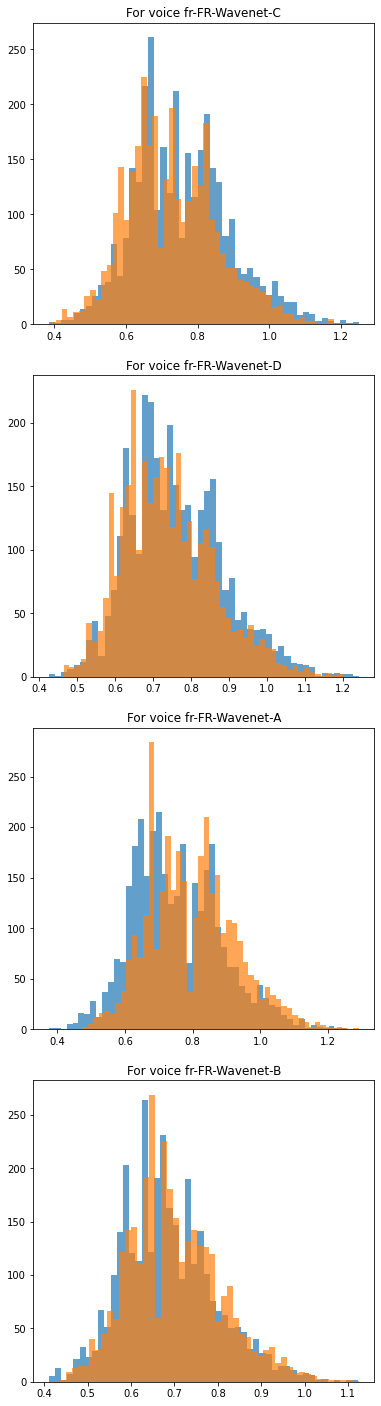

In [21]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes


fig, axs = plt.subplots(len(all_voices), 1)
fig.set_figheight(20)
fig.tight_layout(pad=3.0)

for (voice_id, dur_dict), ax in zip(synthed_audio_durations_nocuts.items(), axs):
    ax: Axes
    ax.hist([durs.text for _, durs in dur_dict.items()], bins=50, alpha=0.7)
    ax.hist([durs.phonetic_true for _, durs in dur_dict.items()], bins=50, alpha=0.7)
    ax.set_title(f"For voice {voice_id}")

plt.savefig("plots/duration_distrib_no_cuts.png")

In [13]:
from paraphone.tasks.filters.base import CandidatesPairCSV
from pathlib import Path
from dataclasses import dataclass
from tqdm import tqdm
from audioread import audio_open
from audioread.gstdec import GstAudioFile
import librosa
import numpy as np
import warnings
warnings.filterwarnings("ignore")


def get_dur(audio_path: Path) -> float:
    array, rate = librosa.load(str(audio_path), sr=None)
    non_zeros = np.nonzero(array)[0]
    true_start, true_end = non_zeros[0], non_zeros[-1]
    return (true_end - true_start) / rate


all_voices = {p.name for p in PHONETIC_SYNTH_DIR.iterdir()}
synthed_audio_durations = {}
for voice_id in all_voices:
    durations_dict = {}
    for word, phonetic, fake_phonetic in tqdm(corpus_64_pairs, total=corpus_64_pairs.lines_count):
        phonetic = phonetic.replace(" ", "_")
        fake_phonetic = fake_phonetic.replace(" ", "_")
        durations_dict[word]= Durations(
            text=get_dur(TEXT_SYNTH_DIR / Path(voice_id) / Path(f"{word}.ogg")),
            phonetic_true=get_dur(PHONETIC_SYNTH_DIR / Path(voice_id) / Path(f"{phonetic}.ogg")),
            phonetic_fake=0.0
        )
    synthed_audio_durations[voice_id] = durations_dict

100%|█████████▉| 3244/3245 [14:29<00:00,  3.73it/s]


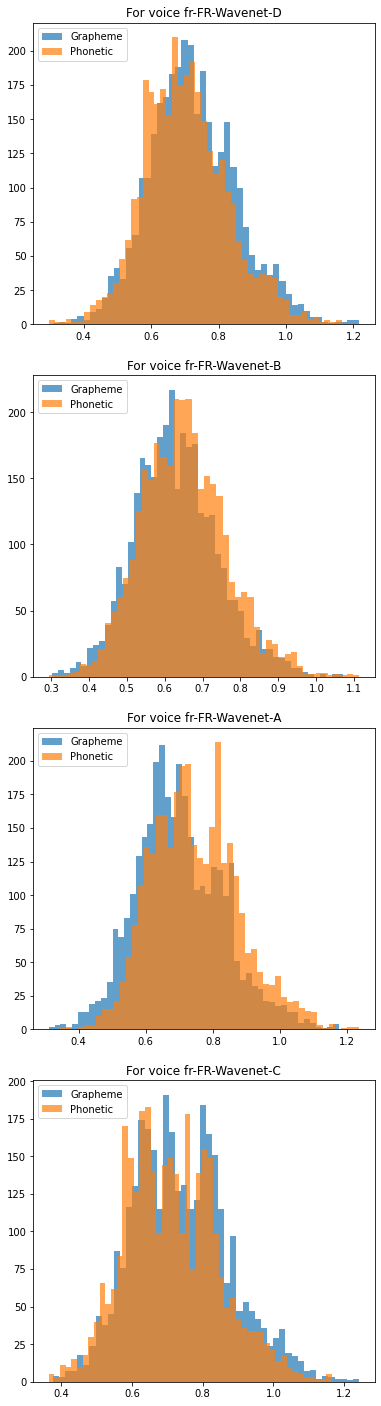

In [19]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sortedcontainers import SortedDict

fig, axs = plt.subplots(len(all_voices), 1)
fig.set_figheight(20)
fig.tight_layout(pad=3.0)

synthed_audio_durations = SortedDict(synthed_audio_durations)
for (voice_id, dur_dict), ax in zip(synthed_audio_durations.items(), axs):
    ax: Axes
    ax.hist([durs.text for _, durs in dur_dict.items()], bins=50, alpha=0.7, label="Grapheme")
    ax.hist([durs.phonetic_true for _, durs in dur_dict.items()], bins=50, alpha=0.7, label="Phonetic")
    ax.set_title(f"For voice {voice_id}")
    ax.legend(loc='upper left')

plt.savefig("plots/duration_distrib_cut.png")

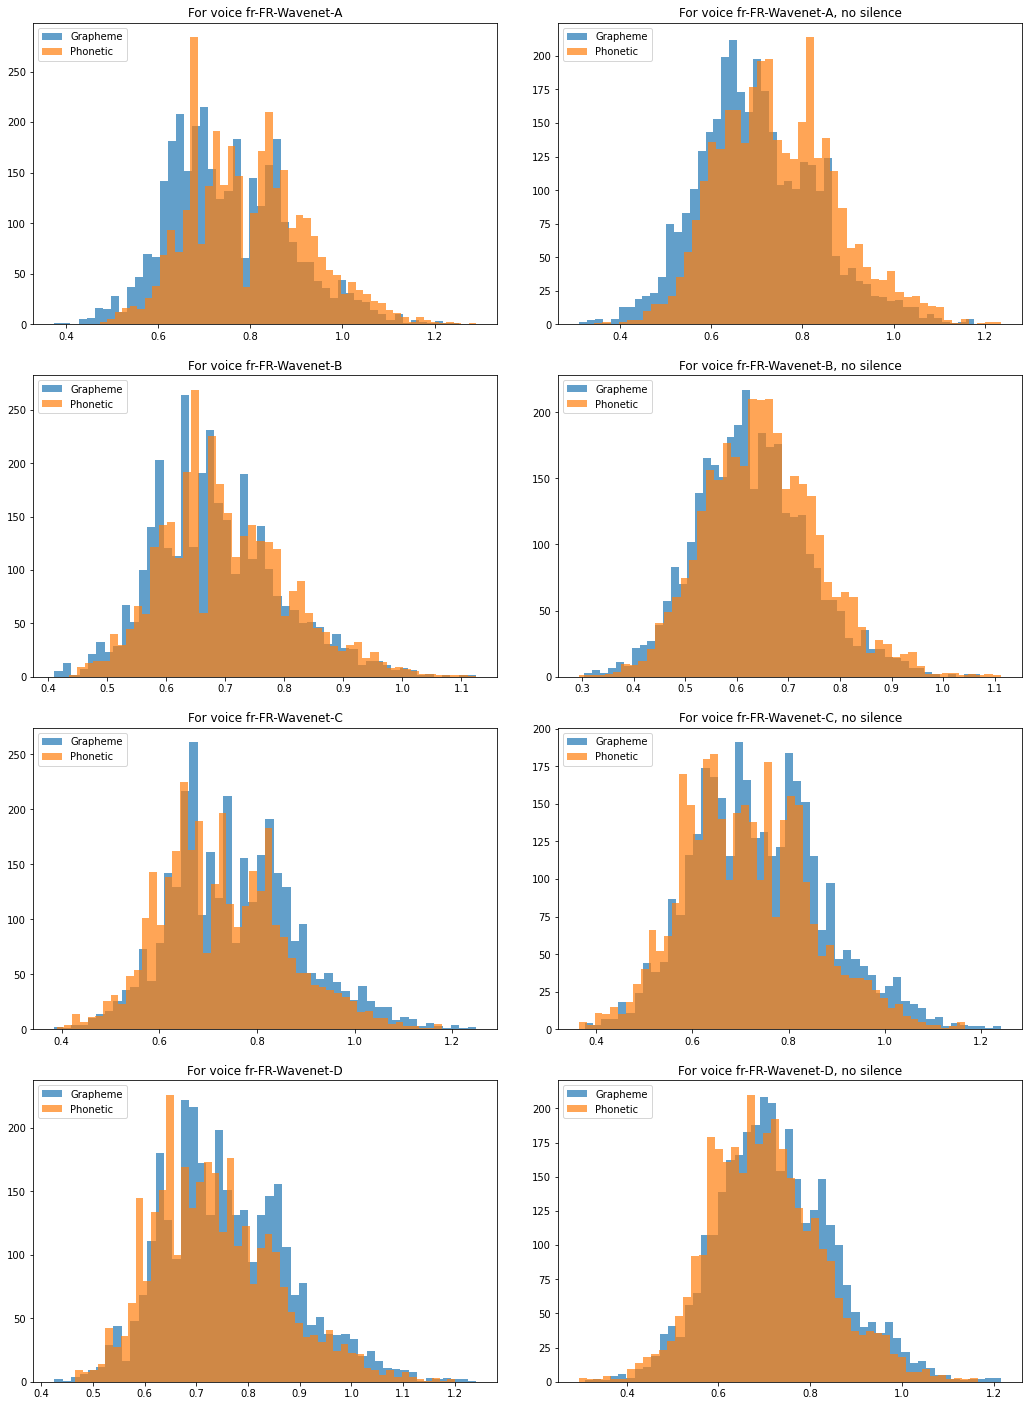

In [26]:
from typing import Dict

fig, axs = plt.subplots(len(all_voices), 2)
fig.set_figheight(20)
fig.set_figwidth(15)
fig.tight_layout(pad=3.0)

def show_hist(ax: Axes, dur_dict: Dict):
    ax.hist([durs.text for _, durs in dur_dict.items()], bins=50, alpha=0.7, label="Grapheme")
    ax.hist([durs.phonetic_true for _, durs in dur_dict.items()], bins=50, alpha=0.7, label="Phonetic")
    ax.legend(loc='upper left')

all_voices_sorted = sorted(list(all_voices))
for voice_id, (ax_nocut, ax_cut) in zip(all_voices_sorted, axs):
    no_cuts_dur_dict = synthed_audio_durations_nocuts[voice_id]
    cuts_dur_dict = synthed_audio_durations[voice_id]
    show_hist(ax_nocut, no_cuts_dur_dict)
    ax_nocut.set_title(f"For voice {voice_id}")
    show_hist(ax_cut, cuts_dur_dict)
    ax_cut.set_title(f"For voice {voice_id}, no silence")

plt.savefig("data/synth_duration_hist_both.png")

Text(0.5, 1.0, 'All voices, without silence')

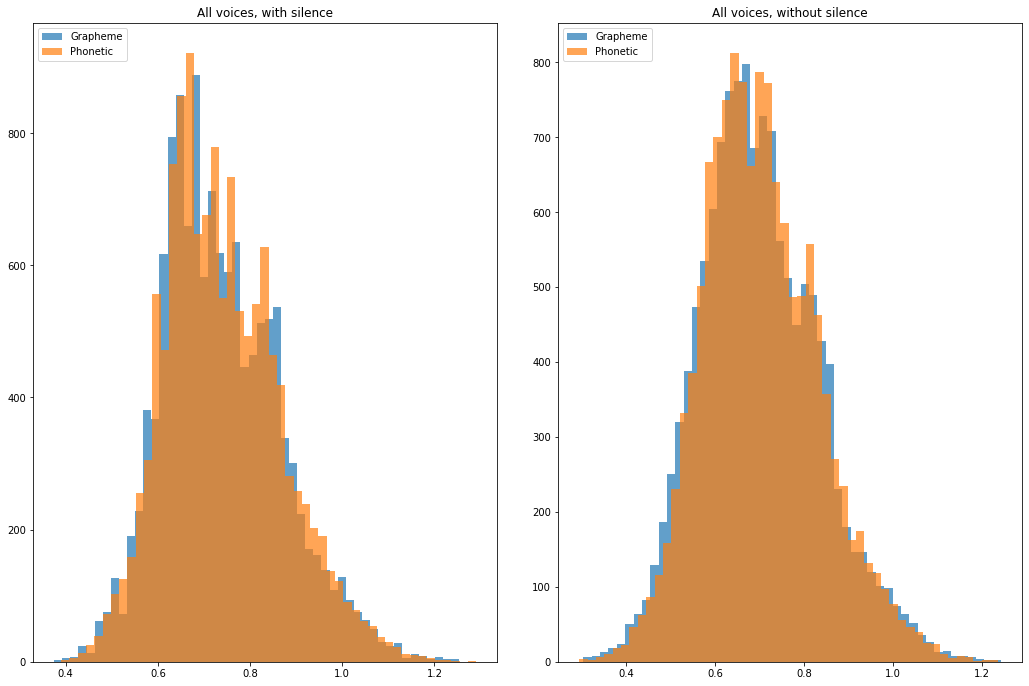

In [28]:
from itertools import chain
from typing import List

def show_hist(ax: Axes, dur_list: List[Durations]):
    ax.hist([durs.text for durs in dur_list], bins=50, alpha=0.7, label="Grapheme")
    ax.hist([durs.phonetic_true for durs in dur_list], bins=50, alpha=0.7, label="Phonetic")
    ax.legend(loc='upper left')

fig, (ax_nocuts, ax_cuts) = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.tight_layout(pad=3.0)
no_cuts_all_dur = list(chain.from_iterable(dur_dict.values() for dur_dict in synthed_audio_durations_nocuts.values()))
cuts_all_dur = list(chain.from_iterable(dur_dict.values() for dur_dict in synthed_audio_durations.values()))
show_hist(ax_nocuts, no_cuts_all_dur)
ax_nocuts.set_title("All voices, with silence")
show_hist(ax_cuts, cuts_all_dur)
ax_cuts.set_title("All voices, without silence")

In [5]:
from paraphone.tasks.filters.base import CandidatesPairCSV
from pathlib import Path
from dataclasses import dataclass
from tqdm import tqdm
from audioread import audio_open, NoBackendError
from audioread.gstdec import GstAudioFile

@dataclass
class Durations:
    text: float
    phonetic_true: float
    phonetic_fake: float

def get_dur(audio_path: Path) -> float:
    try:
        with audio_open(str(audio_path), backends=[GstAudioFile]) as audio_file:
            return audio_file.duration
    except OSError:
        print(f"COuldn't find file {audio_path}")
    except NoBackendError:
        print(f"Couldn't decode file {audio_path}")

AUDIO_SYNTH_DIR = Path("../workspaces/large_fr/synth/audio/")
PHONETIC_SYNTH_DIR = AUDIO_SYNTH_DIR / Path("phonetic")
TEXT_SYNTH_DIR = AUDIO_SYNTH_DIR / Path("text")
wuggy_pairs = Path("../workspaces/large_fr/corpora/wuggy_pairs/")

all_voices = {p.name for p in PHONETIC_SYNTH_DIR.iterdir()}
synth_pairs_durations = {}
for voice_id in all_voices:
    durations_dict = {}
    for wuggy_pairs_path in wuggy_pairs.iterdir():
        wuggy_pairs_csv = CandidatesPairCSV(wuggy_pairs_path)
        for word, _, fake_phonetic in tqdm(wuggy_pairs_csv, total=wuggy_pairs_csv.lines_count):
            fake_phonetic = fake_phonetic.replace(" ", "_")
            durations_dict[word]= Durations(
                text=get_dur(TEXT_SYNTH_DIR / Path(voice_id) / Path(f"{word}.ogg")),
                phonetic_true=0.0,
                phonetic_fake=get_dur(PHONETIC_SYNTH_DIR / Path(voice_id) / Path(f"{fake_phonetic}.ogg"))
            )
        synth_pairs_durations[voice_id] = durations_dict

  0%|          | 8/7341 [00:00<01:38, 74.25it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/trottait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/désolées.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/charmait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/munich.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bibliothécaire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/révolu.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prêtresse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/féerique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/méfait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/irrévocablement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/réclamant.ogg
Could

  1%|          | 41/7341 [00:00<00:58, 125.18it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/graduellement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/désole.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ɛ_z_o_l.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sance.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fournitures.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/jérémiades.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/accoucha.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ébène.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/obscènes.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/découpé.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/réfutation.ogg
COuldn't f

  1%|          | 68/7341 [00:00<01:03, 113.69it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enlevant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɑ̃_m_ə_ʒ_ɑ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/forger.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déplaisaient.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/larmoyant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/meurtrissures.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/finirez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/républicaine.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dégénère.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cultive.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/essuyée.ogg


  1%|          | 91/7341 [00:00<01:08, 105.70it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/frétillant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/coloré.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/abaissa.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/détestant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/barré.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/biscuit.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pâtre.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/désavouer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/romprait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/célèbrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/goguenard.ogg
Couldn't decode file .

  2%|▏         | 117/7341 [00:01<01:02, 115.28it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_ɛ_nj_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mixture.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déportation.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ɛ_p_a_ʁ_m_a_s_j_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/abjection.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gladiateurs.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_l_a_t_j_a_t_œ_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/remontrer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dorénavant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/avoisinent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/f

  2%|▏         | 129/7341 [00:01<01:08, 106.02it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/agaceries.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_ʃ_a_s_ə_ʁ_i.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/collaborateur.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_o_m_a_b_o_ʁ_a_t_œ_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/désolante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enseignera.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɑ̃_v_ɛ_nj_ə_ʁ_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/confessionnal.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hussards.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/atteignirent.ogg
COuldn't find file ../workspaces/large_fr/synth

  2%|▏         | 151/7341 [00:01<01:10, 102.19it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ɛ_t_ɑ̃_t_i_z.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chuchotements.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_w_a_ʁ_ɛ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/éluder.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/puberté.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rassemblèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/érudit.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inconvenant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/acceptant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/contorsions.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ressac.o

  2%|▏         | 172/7341 [00:01<01:20, 89.04it/s] 

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/institut.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_k_l_i_t_ə.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/carriole.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/frugal.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_ʁ_y_ɡ_o_l.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ɛ_f_ʁ_i_f_j_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pharmacie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_a_ʁ_t_a_s_i.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/filiale.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A

  3%|▎         | 184/7341 [00:01<01:15, 94.71it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/répartition.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_p_o_ʁ_t_i_s_j_ɔ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/manufactures.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enterrait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/obtienne.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/buffet.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/capote.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/doléances.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prescrite.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/confondez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/band

  3%|▎         | 226/7341 [00:02<00:58, 120.85it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/siffla.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/câble.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/aimions.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/frac.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_n_a_z.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/borna.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cachetée.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fléchit.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɥ_ɛ_ʒ_i.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/médite.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_ɛ_d_ɛ_s.ogg
COuldn't find file ..

  3%|▎         | 239/7341 [00:02<01:02, 113.58it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/malsaine.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ridiculement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_i_s_i_d_e_l_ə_m_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/insurrection.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/entrions.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɑ̃_t_ʁ_i_j_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sillonnent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/appuyez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/étrangeté.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/entendrez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wav

  4%|▎         | 262/7341 [00:02<01:10, 101.00it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/longer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/l_ɔ̃_k_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/désunir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/aménité.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/intéressait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/obsèques.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/réveillent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/provoqua.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/croissance.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/négligent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/n_o_s_l_i_ʒ_ɑ̃.ogg
Co

  4%|▍         | 287/7341 [00:02<01:04, 110.16it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/agréez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_ɡ_ʁ_u_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tourelle.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_y_ʁ_ɛ_l.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rédigé.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/oscillations.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/éveillait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/effraya.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ôterait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/humainement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/y_p_ɛ_n_i_m_ɑ

  4%|▍         | 318/7341 [00:02<00:53, 131.63it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/concilie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/songeur.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_ɔ̃_z_y_ʁ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déshabille.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ténor.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/recommençant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/babiller.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lynx.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/l_ɛ̃_p_f.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/peler.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/espionner.ogg
COuldn't find file

  5%|▍         | 352/7341 [00:03<00:46, 149.19it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/invoquer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_ɡ_o_v_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bourges.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_u_b_l.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cécité.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/demi-sommeil.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lancèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/laisserez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/monologue.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tôle.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_e_l.ogg
Coul

  5%|▌         | 368/7341 [00:03<00:53, 129.24it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/meuvent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lamenter.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enferme.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/drôlement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/purifie.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gravier.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bouleversait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bave.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/venimeuse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/irrégulière.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/puanteur.ogg
Couldn't decode

  5%|▌         | 396/7341 [00:03<00:55, 125.64it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_u_p_i_ʁ_a_f.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fortifications.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/n_o_ʁ_t_i_f_i_k_a_s_j_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/spéciaux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/veilla.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/louage.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ulysse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/botaniste.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/supporta.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/oratoire.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet

  6%|▌         | 429/7341 [00:03<00:49, 140.48it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ler.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/quadruple.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cognée.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_i_p_j_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bouquins.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pervers.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/galette.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/démoniaque.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lisons.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tendons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lazare.ogg
Couldn't decode file ../

  6%|▋         | 460/7341 [00:03<00:49, 139.76it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/réservant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/décevant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/parabole.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pauline.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/collatéraux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_o_m_a_t_ɛ_ʁ_o.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/envahir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dauphine.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/figuier.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/crotte.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_ʁ_ɛ_m.ogg
C

  7%|▋         | 493/7341 [00:04<00:45, 150.86it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/v_a_l_i_k_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/nageur.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/négocier.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tunis.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/nombril.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dormez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/amènera.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/impétueusement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/voulussent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gril.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hamlet.ogg
Couldn't decode file ../

  7%|▋         | 509/7341 [00:04<00:49, 138.12it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/artistement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_l_t_i_k_s_ə_m_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/immondices.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/i_m_ɔ̃_d_i_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/concile.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/épanchements.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bourbeux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/nef.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/stratagème.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_l_w_a_t_a_ʒ_ɛ_m.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR

  7%|▋         | 542/7341 [00:04<00:46, 146.30it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/recouvra.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/montrons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exclure.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ressouvenir.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ə_v_u_d_ə_n_a_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_i_nj_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/latérale.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_a_m_ɛ_ʁ_a_l.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/contrefaite.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/incompatible.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Waven

  8%|▊         | 576/7341 [00:04<00:44, 152.30it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/almanach.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/maquignon.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/crocodile.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ʁ_ɛ_p_o_d_e_l.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déshabiller.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/étourdiment.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/piémont.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_j_e_m_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gascon.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_a_k_l_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dénon

  8%|▊         | 607/7341 [00:04<00:46, 145.21it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/simultanément.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_i_m_y_ʁ_l_a_n_ɛ_m_ɑ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rangèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/institutions.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mandataire.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ɑ̃_f_a_t_ɛ_ʁ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/provoque.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/marge.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/facture.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/descendra.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-

  9%|▊         | 638/7341 [00:05<00:45, 148.61it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/demandiez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/approvisionnements.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_p_ʁ_o_b_i_ʒ_j_o_n_ə_m_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rafales.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/barricader.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/niaisement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bouchon.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/once.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/embouchure.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/menèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/

  9%|▉         | 670/7341 [00:05<00:45, 146.56it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/préau.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/liséré.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dion.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/v_l_ɛ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/trompant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/physiologie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prescrivit.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/concluait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/garance.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/oppresseurs.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/engourdissement.ogg
COuldn't

 10%|▉         | 702/7341 [00:05<00:44, 149.18it/s]


COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/redoublement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ə_b_u_b_l_ə_m_ɑ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chantera.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/apporterait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bouillait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/arrêtera.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fangeuse.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/usurpation.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fuseau.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gratification.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_k_a_t

 10%|█         | 736/7341 [00:05<00:42, 156.61it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/représailles.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cessèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déviation.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/suggestion.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/professent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/éclose.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/corniche.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tortueuses.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_o_ʁ_m_y_ø_z.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/irrite.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inoffensive.ogg
Coul

 10%|█         | 752/7341 [00:05<00:43, 150.41it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bijoutier.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/institua.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/entassent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exigea.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_v_ʁ_i_ʒ_a.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/expédié.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_k_s_m_ɛ_t_j_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sema.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/idolâtres.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/glapissant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tulle.ogg
COuldn't 

 11%|█         | 783/7341 [00:06<00:46, 141.32it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dévouements.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_e_s_u_z_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/manqueront.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/obligeant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/réveillerait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/agissante.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_j_i_m_ɑ̃_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/présenterait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cardinaux.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/balbutier.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavene

 11%|█         | 814/7341 [00:06<00:45, 144.34it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/supercherie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_y_n_ɛ_ʁ_ʃ_ə_ʁ_i.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rubiconde.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/jugèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/aumônier.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/o_m_o_ʁ_j_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/recouverte.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ə_k_u_v_ɛ_n_d.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/témoignant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/blafarde.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/

 12%|█▏        | 847/7341 [00:06<00:45, 143.70it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cohabitation.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/promouvoir.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fredonner.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/continuâmes.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/douaniers.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_s_a_n_j_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/anxiétés.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/distribue.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/poétiquement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/impunité.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_a_

 12%|█▏        | 862/7341 [00:06<00:46, 139.37it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/corollaire.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/écrier.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dévot.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tinter.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sauverons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/follets.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mesdemoiselles.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/battez.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/apprêter.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/envisage.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/attenant.ogg
Couldn't decode file ..

 12%|█▏        | 890/7341 [00:06<00:54, 119.31it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/turban.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cahier.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_a_b_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/énumérer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vanta.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vaquer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/explorer.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_k_s_k_l_o_ʁ_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/implicitement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_p_l_i_k_i_ʃ_ə_m_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exorcism

 13%|█▎        | 921/7341 [00:07<00:47, 134.38it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/frénétique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/riante.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/patienter.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_a_z_j_ɑ̃_t_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_b_ʁ_ɛ_s_f_a_s_j_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bénissait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_e_v_i_s_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/arabesques.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/huées.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/irritable.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-

 13%|█▎        | 951/7341 [00:07<00:46, 137.46it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/immoler.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/survivait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/découlent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_s_e_l_y.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lisbonne.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bercé.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/défroque.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_e_k_t_o_k.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/confessant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/méchamment.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_ɛ_ʒ_a_m

 13%|█▎        | 987/7341 [00:07<00:41, 153.88it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/entonnoir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mante.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/soucieuse.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_u_s_k_ø_z.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/conspirait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_p_t_i_ʁ_ɛ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ricanant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exubérance.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_ɡ_z_e_b_ɛ_ʁ_ɑ̃_s.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/frimas.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/aba

 14%|█▍        | 1019/7341 [00:07<00:41, 150.78it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/embarcation.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/imprima.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/badinage.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/éprouvèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/jauni.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_i_t_i.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/carmin.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pharisiens.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/galons.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/régulateur.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enviable.ogg
COuldn't find file ..

 14%|█▍        | 1055/7341 [00:07<00:38, 161.43it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_y_j_i.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/finances.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/v_i_n_ɑ̃_d.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ralentissant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_a_p_ɑ̃_t_i_s_ɑ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prédit.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déconvenue.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/urgent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/normand.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/changerait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/circulaient.

 15%|█▍        | 1072/7341 [00:08<00:42, 146.97it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/jurent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/retarde.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dispos.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/étouffa.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/carnation.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/reverrons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déçu.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/toronto.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/carrure.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/féline.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/injurier.ogg
Couldn't decode file ../worksp

 15%|█▍        | 1101/7341 [00:08<00:47, 130.14it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/soulageait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/félicitait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inimitié.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pervertir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/métempsycose.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/clairvoyance.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_l_ɛ_ʁ_v_w_a_j_ɑ̃_s.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/intrus.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/démentait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gendarmerie.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/n_

 15%|█▌        | 1130/7341 [00:08<00:49, 126.00it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/divertir.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/redoubla.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ə_d_u_k_ʁ_a.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/choisissez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/irresponsable.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/arrangea.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/consolider.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ébahi.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/nancy.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/duo.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_u_ɛ.ogg
Couldn't dec

 16%|█▌        | 1162/7341 [00:08<00:45, 135.51it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dressèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/méprendre.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_ɛ_f_ʁ_ɑ̃_d_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fumante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/indigestion.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_d_i_ʒ_ɛ_k_k_j_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/opulent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/o_p_y_t_ɔ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mexique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/saisissons.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet

 16%|█▋        | 1195/7341 [00:09<00:41, 149.73it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/paternité.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/achèvent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dérouler.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hérissés.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/moscovite.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/contempla.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/amusant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/moisissure.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gymnastique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/engageait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rejetez.ogg
Couldn't 

 16%|█▋        | 1211/7341 [00:09<00:45, 133.61it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/méditatif.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/accommoder.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/flegmatiquement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/garnissaient.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gauchement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/scellé.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/v_i_ʁ_t_y_o_k.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ur.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/frissonna.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/friche.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/quittâmes.ogg
COuldn'

 17%|█▋        | 1240/7341 [00:09<00:45, 134.88it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rajusta.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inventa.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_j_ɑ̃_d_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/offrez.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/o_p_l_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vidant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/v_i_j_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/camisole.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_a_m_i_z_ø_l.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fichue.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/v_i_ʃ_y.ogg
Co

 17%|█▋        | 1276/7341 [00:09<00:41, 147.34it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/christianisme.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gratuits.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_ʁ_i_ɡ_j_i.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/brasier.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/artillerie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_l_t_i_ɡ_ə_ʁ_i.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/feutre.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/monacale.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cupidon.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/accéléré.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/smyrne.ogg
C

 18%|█▊        | 1306/7341 [00:09<00:42, 142.42it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/transformant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_ʁ_ɑ̃_s_b_o_ʁ_s_ɑ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/traduisit.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/panique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/l_a_t_a_k.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pleurèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hongrie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/stoïcisme.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ouvrirent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/jérémie.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʃ_e

 18%|█▊        | 1339/7341 [00:10<00:40, 147.86it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/maintenait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/réclamons.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ɛ_p_l_a_m_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grabat.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_ʁ_a_ʃ_a.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/suivront.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/confine.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_ʃ_i_n.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cousu.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/petit-fils.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pointait.ogg


 19%|█▊        | 1368/7341 [00:10<00:47, 126.61it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lucidité.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/supposa.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/résolurent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/touchons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_y_b_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/contredit.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pelote.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/impérieuses.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/traiterait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_ʁ_ɛ_t_ə_ʁ_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/écrin.ogg
C

 19%|█▉        | 1409/7341 [00:10<00:37, 159.37it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déroger.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/détachèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_ɔ̃_b_a_b_l.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/frayait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_l_e_ʃ_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/concourent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/jetterait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/applicable.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_s_p_i_d_a_b_l.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/soporifique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wave

 20%|█▉        | 1446/7341 [00:10<00:34, 169.52it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dépité.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/désastreux.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/noircir.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ʒ_a_ʁ_d_i_ʁ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/persévérer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ɛ_ʁ_m_ɛ_v_ɛ_ʁ_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bourbon.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/devront.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ə_t_j_ɔ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/régal.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_ɡ_a_l

 20%|██        | 1484/7341 [00:10<00:34, 171.81it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/éminente.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lorraine.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/partiez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/l_a_ʁ_t_s_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sarrasin.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/flamands.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/frottait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/holocauste.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/o_l_o_k_y_s_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rai.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/concevait.ogg
C

 20%|██        | 1502/7341 [00:11<00:37, 155.10it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inhabitée.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/restreindre.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ɛ_s_k_l_ɛ̃_k_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/connurent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_o_v_y_ʁ_y.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bréviaire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lactée.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/l_a_p_l_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/aubergiste.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/o_z_ɛ_ʁ_ʃ_i_s_t.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-

 21%|██        | 1533/7341 [00:11<00:42, 135.09it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/narcisse.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/n_a_ʁ_n_a_s.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fléchissent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/charte.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_a_v_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/agirait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/accompagnèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_f_o_ʁ_m_ə_m_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/indécente.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_p_ɛ_s_ɑ̃_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wav

 21%|██        | 1547/7341 [00:11<00:45, 128.50it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gageure.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_a_ʃ_y_ʁ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/palefrenier.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/apologie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/concernent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_p_ɛ_ʁ_t_y.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/effervescence.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/léonard.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/oublieuse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/u_ɡ_ʁ_i_s_ø_z.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavene

 21%|██▏       | 1573/7341 [00:11<00:52, 110.53it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prive.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/boulanger.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/payerai.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/camaraderie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rieur.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bienfaisantes.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_l_ɑ̃_l_ə_k_ɑ̃_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/complimenter.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/buée.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/diète.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/creusa.ogg
Co

 22%|██▏       | 1607/7341 [00:11<00:42, 135.61it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prendront.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ʁ_ɑ̃_p_l_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/schisme.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʃ_ɔ̃_nj.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/périrait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pompeusement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rabattu.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/athlète.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/accusera.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_n_y_v_ə_ʁ_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/épanou

 22%|██▏       | 1622/7341 [00:12<00:42, 135.33it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/plaisance.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/apaisement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_n_ɛ_z_ə_m_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/intuition.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/remplaçait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/valurent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/recherchent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/muscade.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_y_s_j_i_j.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/anéanties.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rejointe.

 22%|██▏       | 1651/7341 [00:12<00:43, 131.80it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/avouerez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/batelier.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_a_t_ə_f_j_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rétribution.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rené.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/requérir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ə_p_ɛ_ʁ_i_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dévouer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dévotement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/confrontation.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exal

 23%|██▎       | 1680/7341 [00:12<00:45, 125.25it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/impertinence.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grondant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/préméditation.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/whist.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/aimerais.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/geôlier.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rentrâmes.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/haineux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/filtrait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/apparaîtra.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/philosophale.ogg
Could

 23%|██▎       | 1706/7341 [00:12<00:48, 116.29it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cherbourg.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/trépas.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fourberie.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/coûterait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/moqueuse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_o_z_u_z.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/médicis.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_e_d_i_s_a_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pronom.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vénéré.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/induire.ogg
Couldn'

 24%|██▎       | 1736/7341 [00:12<00:42, 131.62it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/expiation.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/arrivions.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tutoyer.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vendée.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gagnerait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/aristote.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/interrogeant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_t_ɛ_t_o_k_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/kiosque.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/z_j_o_k_d.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/aloi.o

 24%|██▍       | 1750/7341 [00:13<00:42, 130.46it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/atlas.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/européens.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ə_ʁ_o_f_ɛ_ɛ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/avertissait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_s_ɛ_ʁ_s_i_l_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rembourser.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sauvons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/craquait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exhiba.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/blottir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/abstine

 24%|██▍       | 1778/7341 [00:13<00:43, 128.82it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rohan.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/l_o_i_n.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/conviendrez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/feignait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/blâma.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/doublure.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_u_k_l_y_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/opposant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/maintenon.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/voguait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cabestan.ogg
COuldn't 

 25%|██▍       | 1808/7341 [00:13<00:40, 137.36it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cramponna.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/supprime.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_y_p_l_i_m.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/anachronisme.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/trottant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/commodités.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/matrimoniale.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exprimant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/erronée.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/partirai.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_a_ʁ_l_i

 25%|██▌       | 1839/7341 [00:13<00:38, 143.21it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/escorté.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inonda.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/i_s_ɔ̃_s_a.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lucien.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/l_u_s_t_ɛ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sui.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ressentent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/saisirait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rompirent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/proviennent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grillage.ogg
Couldn't decode

 26%|██▌       | 1876/7341 [00:13<00:34, 160.67it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/intelligibles.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pénates.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_e_n_a_s.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/débordante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/recteur.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ɛ_d_ʁ_œ_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/respectent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/partirez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/allègre.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lucide.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sagace.og

 26%|██▌       | 1912/7341 [00:14<00:34, 155.72it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/réussirent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/reverrez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ə_k_ɛ_ʁ_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/expressive.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/célébra.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_e_l_e_p_j_a.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/crépitement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/friponnerie.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_p_i_p_o_n_ə_ʁ_i.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/volage.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wav

 26%|██▋       | 1945/7341 [00:14<00:34, 156.97it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/supplée.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/détendre.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rescousse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/assurent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/amante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/admettons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/saccades.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/indubitable.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/disparaisse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/graisseux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/réitérées.ogg
Couldn'

 27%|██▋       | 1981/7341 [00:14<00:35, 153.11it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/brancard.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_ʁ_ɑ̃_k_ɛ_ʁ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/imminent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/démission.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/arche.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/i_d_ʒ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/abdication.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_ɡ_m_i_k_a_s_j_ɔ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/attrape.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fervente.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mettrez.ogg
Could

 27%|██▋       | 2017/7341 [00:14<00:32, 162.94it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bienséance.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ʒ_ɛ̃_s_ɛ_ɑ̃_s.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sautèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exorde.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/saint-honoré.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pourvoit.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_u_ʁ_n_j_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/oppressait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prêchait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/punique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/effec

 28%|██▊       | 2034/7341 [00:14<00:36, 143.54it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rira.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ténébreuses.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_e_n_e_k_j_ø_z.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bambou.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/meunier.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tapait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_a_v_o.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/courba.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pastorale.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_a_s_p_o_ʁ_a_l.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/traire.ogg
CO

 28%|██▊       | 2066/7341 [00:15<00:34, 150.75it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/surprendra.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/oracles.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bitume.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_i_n_e_m.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/augmentent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rance.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɑ̃_k.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cédèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pratiquement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ʁ_a_ʁ_i_z_ə_m_ɑ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hangar.ogg

 29%|██▊       | 2102/7341 [00:15<00:32, 162.67it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/comportait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/obole.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/aérien.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tolère.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/usurpateur.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/y_z_œ_ʁ_ɡ_a_t_œ_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/nuageux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_y_a_v_ø.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/acquiert.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/préfets.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/choléra.ogg


 29%|██▉       | 2137/7341 [00:15<00:32, 162.17it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/perverse.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/plaindra.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bilan.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_i_l_o_n.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/jurerais.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʃ_y_l_ə_ʁ_ɛ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/thébaïde.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/flatta.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/contribua.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/reconnaissable.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rapprochèrent.ogg
COu

 30%|██▉       | 2174/7341 [00:15<00:30, 167.54it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/protestante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/élire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/houle.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/e_n.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/destinais.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/objecta.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/o_p_ʒ_ɛ_t_ʁ_a.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/engins.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɑ̃_ʃ_ɛ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fournisseurs.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/teneur.ogg
Couldn't dec

 30%|███       | 2210/7341 [00:16<00:30, 167.23it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bicêtre.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/désireuse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exhaler.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/causerons.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rançonner.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/médiateur.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_ɛ_ʁ_w_a_t_œ_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/reptiles.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ɛ_ɡ_l_i_l.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rubens.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sautoir.ogg
Couldn'

 31%|███       | 2247/7341 [00:16<00:29, 171.41it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sentencieux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_ɑ̃_t_ɑ̃_f_l_ø.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/jérôme.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/remplacement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/corsaire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/titus.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_i_n_u_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/corrompre.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/perçoit.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/éloquemment.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/e_

 31%|███       | 2285/7341 [00:16<00:29, 173.80it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_u_z_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dague.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_o_ɡ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/carrément.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/quinte.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ressemblerait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ə_v_ɑ̃_k_t_ə_ʁ_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/quid.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_s_i_d.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/resplendir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dégag

 32%|███▏      | 2322/7341 [00:16<00:28, 175.61it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/commerciaux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grouillait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ʁ_y_j_o.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sommelier.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_o_m_ə_t_ʁ_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/éloignent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/larcin.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/attestent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/céderait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_ɛ_ɡ_ə_ʁ_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/

 32%|███▏      | 2359/7341 [00:16<00:28, 173.25it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/impertinent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/présidence.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chinoise.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/spécimen.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/souviendrai.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/repaître.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/professionnelle.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/repentant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dogmatique.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/barbier.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cataracte.ogg
Co

 33%|███▎      | 2401/7341 [00:17<00:26, 189.57it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bâillement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fournira.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/démontre.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_m_ɔ̃_d_ɥ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/poitiers.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/galopant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vendôme.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_ɑ̃_k_ə_m.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chartreuse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/montrerez.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_ɔ̃_p_

 33%|███▎      | 2440/7341 [00:17<00:27, 181.26it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/guidait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_i_k_ɛ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/débarquement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_ɡ_a_ʁ_b_i_m_ɑ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/clairsemés.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/persiennes.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ɛ_ʁ_ɡ_z_ɛ_n.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fâchait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sacrificateur.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/raphaël.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet

 33%|███▎      | 2459/7341 [00:17<00:28, 170.35it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_i_b_ʁ_ɛ_ʁ_s_ɛ_ʁ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/indissolublement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cornette.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/remerciant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ə_m_ɛ_ʁ_d_j_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ivoire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/feuilleter.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_ə_ʃ_ə_t_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/immatériel.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/i_m_a_t_ɛ_ʁ_j_a_l.ogg
Couldn't decode file ../workspaces/large_fr/synth/a

 34%|███▍      | 2495/7341 [00:17<00:29, 163.38it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/effleurait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/torturait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/goulot.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/v_y_ʁ_o.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/légataire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tri.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/allocution.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bannière.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/coupole.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/corset.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chimériques.ogg
Couldn't decode 

 35%|███▍      | 2533/7341 [00:17<00:27, 173.14it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/convainquit.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ptolémée.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_w_ɛ_l_e_m_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/intimider.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_t_i_s_i_ɡ_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/embrasure.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/renouvelant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ə_n_u_d_ə_l_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/éprouvez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/e_b_ʁ_u_v_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-

 35%|███▍      | 2568/7341 [00:18<00:30, 155.62it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/causera.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/flexibilité.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/barthélémy.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/causions.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vende.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/stoïciens.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/indiquent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/financier.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déroba.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/redoutent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bassement.ogg
COuldn't find fi

 35%|███▌      | 2584/7341 [00:18<00:32, 146.07it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/confirment.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/corporelle.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_o_ʁ_p_o_ʁ_ɛ_n.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dément.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/havane.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/continuons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/débutait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/express.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_s_d_ʁ_w_ɛ_s.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vivifier.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prévention.ogg
COuldn'

 36%|███▌      | 2614/7341 [00:18<00:34, 136.67it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/détroit.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/crouler.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/conduise.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/infidèles.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/traçant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/somptueuse.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/soigne.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/excitèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_s_p_i_t_ɛ_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/baldaquin.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_a_l_n_a_k_ɛ̃.ogg


 36%|███▌      | 2644/7341 [00:18<00:35, 133.92it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/insultante.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/persista.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/descendons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dessine.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_z_a_n.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enseigna.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɑ̃_p_ɛ_nj_a.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/esthétique.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/toge.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/avalait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chassèrent.ogg
COuldn

 36%|███▋      | 2678/7341 [00:18<00:30, 151.17it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/édit.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/comptions.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_ʃ_m_ɔ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/voilier.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/emporterait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/impalpable.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/logicien.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/constatons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_d_w_a_l_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/usurier.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/y_z

 37%|███▋      | 2713/7341 [00:19<00:28, 161.37it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/relevèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/coffret.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/converser.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/clémente.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pratiquait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ʁ_a_t_i_d_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/désirables.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/concurrents.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_k_y_ʁ_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/retranche.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A

 37%|███▋      | 2746/7341 [00:19<00:30, 151.74it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inhabile.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/embrassent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɑ̃_t_j_a_s_y.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/suppléait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mi-chemin.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fantasque.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_ɑ̃_t_a_b_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/richelieu.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_i_ʒ_ə_d_j_ø.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/allumèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavene

 38%|███▊      | 2783/7341 [00:19<00:27, 166.05it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_ɛ_b_o_n_ɛ_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/réalisent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/osons.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hésitants.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/entonna.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɑ̃_s_o_n_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/heurtaient.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/comptons.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/célébrait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/débiter.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grenouille.ogg
Cou

 38%|███▊      | 2817/7341 [00:19<00:27, 161.78it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ménagement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/aptitude.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/spéculation.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/valser.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prototype.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_t_ʁ_ə_b_ɑ̃_t_j_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/delphes.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_l_s.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/extravagant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/écorcher.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet

 39%|███▉      | 2852/7341 [00:20<00:27, 161.86it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/subissons.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_y_b_i_j_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/engendre.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ruminant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_y_m_i_n_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/insensibilité.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/unissait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/your.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/piastres.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gueuse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/missionnaire.og

 39%|███▉      | 2891/7341 [00:20<00:26, 171.15it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/punissait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_y_v_i_s_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ricanement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cheminant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʒ_ə_t_i_n_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/transversale.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prétoire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_ʁ_ɛ_p_w_a_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/attaqua.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_m_a_v_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR

 40%|███▉      | 2909/7341 [00:20<00:26, 167.74it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/décourage.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gland.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/écrive.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/épousez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/e_n_e_z_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/phénix.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/couplet.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_u_s_p_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/arabie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/achevons.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/avalanche.ogg
Couldn't deco

 40%|████      | 2946/7341 [00:20<00:25, 170.52it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/muletier.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bourgogne.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grimpèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ʁ_ɛ̃_ʒ_ɛ_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gouvernants.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vitraux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_i_n_j_o.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grimpant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/percent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ɛ_ʁ_m_ø.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/débilité.ogg


 41%|████      | 2984/7341 [00:20<00:26, 167.13it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hermaphrodite.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/poursuivons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_y_ʁ_n_j_i_v_ɔ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/subterfuges.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/embaumé.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/séditieux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/démocratique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/balthazar.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/somnolence.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_o_d_j_o_l_ɑ̃_s.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-

 41%|████      | 3021/7341 [00:20<00:24, 173.15it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_e_j_ɑ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/admirent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_z_n_i_ʁ_ə.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/commandent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/parvenons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/flanqué.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/proclame.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/châtié.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/embellir.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bercail.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/significative.ogg
Couldn'

 41%|████▏     | 3039/7341 [00:21<00:27, 158.98it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/recouvrir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rasa.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fauché.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/retournera.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/surent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/directoire.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/désirerais.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_e_v_i_ʁ_ə_ʁ_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fréquentant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_ʁ_ɛ_k_ɑ̃_t_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/maniait.o

 42%|████▏     | 3072/7341 [00:21<00:28, 148.07it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lava.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/l_a_j_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rugissant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_y_ʃ_i_j_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pétrole.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ɛ_v_ʁ_i_l.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/levons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/abat-jour.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sciure.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/modification.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_o_

 42%|████▏     | 3104/7341 [00:21<00:29, 144.74it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/avalant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/arrosa.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_l_o_d_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rangeait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/progéniture.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dénoués.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/eo.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déchéance.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/effaça.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/frémissait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/junon.ogg
Couldn't decode file

 43%|████▎     | 3134/7341 [00:21<00:30, 137.94it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tardait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inséparable.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/illuminent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/huitaine.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/créatrice.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cuisinière.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_l_i_z_i_n_j_ɛ_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/empoisonneur.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/casaque.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/regardions.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ca

 43%|████▎     | 3162/7341 [00:22<00:31, 133.12it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/arrondir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/décédé.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_v_ɛ_d_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sourciller.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/samuel.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/jaser.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/effrayez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tempérance.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/célibataire.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inhérente.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gratter.ogg
COuld

 43%|████▎     | 3177/7341 [00:22<00:30, 136.81it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/méprisez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/précédaient.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/élite.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_l_i_k.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pressèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vigie.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_i_ʃ_i.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ramer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tourbe.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prisme.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sarcasmes.ogg
Couldn't decode

 44%|████▎     | 3204/7341 [00:22<00:36, 113.15it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tondre.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/nia.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/renonçons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/avouant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lycée.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/conservèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prêtèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/boulangère.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/engeance.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɑ̃_ʒ_ɑ̃_d.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/noviciat.ogg
Couldn't

 44%|████▍     | 3235/7341 [00:22<00:31, 129.21it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/entassement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɑ̃_t_a_m_i_m_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chaleureusement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/redisait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ə_z_i_z_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/boirez.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_j_a_ʁ_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dissipait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sardaigne.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/expirait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fi

 44%|████▍     | 3264/7341 [00:22<00:30, 131.79it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pestiférés.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ɛ_s_t_i_p_ɛ_ʁ_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/couchèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/adorateurs.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_f_o_t_a_t_ɛ_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prospérer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/plantant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hâtif.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_n_ɛ_ɡ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/scalpel.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/nou

 45%|████▍     | 3292/7341 [00:23<00:31, 126.97it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sacoche.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_a_z_ɛ_v.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déshonorent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/digue.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/autorisation.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exténué.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/unissant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/y_s_i_j_ɑ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/volumineux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mitre.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déposant.ogg
COuldn

 45%|████▌     | 3324/7341 [00:23<00:28, 142.60it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/distribuait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_i_p_s_t_i_b_y_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/clairière.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fiole.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prémédité.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/regagne.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/encourageant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/logent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/l_o_ɡ_ø.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/life.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/l_a_z_ɥ.ogg


 45%|████▌     | 3340/7341 [00:23<00:27, 144.43it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/despote.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_ʁ_w_i_t.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enseveli.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/austérités.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/obéissante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rhône.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/will.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/distinguant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/escadron.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/désignation.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/significatif.ogg
Cou

 46%|████▌     | 3372/7341 [00:23<00:27, 146.86it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/platanes.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rompant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hésitent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sablonneux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/interjections.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_t_ɛ_ʁ_l_y_p_s_j_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/disgracié.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/majeure.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/arrogante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déboucher.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/

 46%|████▋     | 3407/7341 [00:23<00:25, 156.17it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/samson.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɑ̃_b_i_n.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fastidieuse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/charnier.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/intacte.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/malveillance.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/asservissement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/courroucé.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rageusement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/accourant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/trente-h

 47%|████▋     | 3440/7341 [00:24<00:24, 157.59it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/denys.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/trébucher.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mixte.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tracasse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dieppe.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/n_j_ə_p.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/garnement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/admettent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_b_m_ɛ_t_ə.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/amorce.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/procurait.ogg
Couldn't decode fi

 47%|████▋     | 3476/7341 [00:24<00:23, 163.65it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rixe.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/suspension.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_y_s_k_ɑ̃_s_j_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ballade.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gutenberg.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mélodrame.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/remboursement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/galopait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mendie.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pompadour.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/allumait.ogg


 48%|████▊     | 3509/7341 [00:24<00:25, 147.73it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/confirmant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/épousait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/suffiront.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rond-point.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bergerie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/intelligemment.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/assommé.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_n_o_m_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gaillardement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/conservateur.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/belliqueu

 48%|████▊     | 3541/7341 [00:24<00:25, 148.89it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/certifier.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bondissait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/agisse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prononciation.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déplia.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/traînèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/saisira.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/banal.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/brillamment.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ci-après.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_i_a_ʃ_j_ɛ.ogg
COuldn't fin

 49%|████▊     | 3577/7341 [00:24<00:23, 158.88it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sorcière.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/avertissent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/imparfaitement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vélin.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/encouragea.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɑ̃_p_u_t_a_k_a.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bâillait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/penserait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_ɑ̃_b_ə_ʁ_ɛ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grincer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/épouvanta

 49%|████▉     | 3612/7341 [00:25<00:22, 165.09it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/persistance.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sauvagerie.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_i_v_a_j_ə_ʁ_i.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dédommagement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/radical.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_a_d_i_d_ɛ_l.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/imprime.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_b_l_ɛ_m.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/serrurier.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_o_ʁ_y_s_t_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-W

 49%|████▉     | 3630/7341 [00:25<00:22, 167.54it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rogue.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_ø_v.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tutoyait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/noya.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inimitable.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/éloignaient.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/intercéder.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/catalogue.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/phalange.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/doublant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/contester.ogg
COuldn't 

 50%|█████     | 3679/7341 [00:25<00:23, 158.07it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tairai.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/démentit.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/craigne.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ʁ_a_nj.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/affermir.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/trouverions.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/retrouvèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/opprimés.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/blanchisseuse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_w_ɑ̃_ʃ_i_s_ø_z.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/crispa

 50%|█████     | 3695/7341 [00:25<00:24, 150.00it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/entrebâillée.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/xxx.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/consacra.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_s_a_b_ʁ_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/divertit.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/séduisent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/recluse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inconsolable.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/descendante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/comprendront.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/possédât.ogg


 51%|█████     | 3732/7341 [00:25<00:21, 165.13it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hurlait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prendriez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ʁ_ɑ̃_b_l_i_j_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/violer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_j_o_l_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/transportèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/étreint.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_l_j_ɛ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/morfondre.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/réjouissait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rép

 51%|█████▏    | 3768/7341 [00:26<00:21, 168.38it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_y_s_p_ɛ_v_ʁ_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déclinait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_e_f_ʁ_i_n_ɛ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/équipée.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/annoncent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_k_ɔ̃_d_y.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/furetant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/statistique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_t_a_t_i_n_j_i_k.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/navre.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A

 52%|█████▏    | 3804/7341 [00:26<00:21, 162.18it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/planta.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ensoleillée.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dresde.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/devenez.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/justification.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sèment.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_ɛ_s_ø.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/madian.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tage.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/statuette.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/scott.ogg
Couldn't decode file ../

 52%|█████▏    | 3843/7341 [00:26<00:19, 177.86it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/commentateurs.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lourdeur.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/caressés.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/concourir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/apostrophe.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_p_o_s_t_ʁ_i_ʒ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sensuel.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/convinrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_v_ɛ̃_b.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/corvée.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-

 53%|█████▎    | 3879/7341 [00:26<00:20, 170.17it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sénateurs.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/jetons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʃ_ə_t_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prévaloir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ʁ_ɛ_v_a_d_w_a_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gaspiller.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hongrois.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/capiteux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/outré.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/défilaient.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/étouffen

 53%|█████▎    | 3916/7341 [00:26<00:20, 166.93it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/crosse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fissiez.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/belliqueuse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/invalides.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sautillant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rafraîchissements.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chignon.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/persévérant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sévir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lib.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/madriers.ogg
Couldn't d

 54%|█████▍    | 3951/7341 [00:27<00:19, 169.59it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pituite.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_i_ʁ_k_ʒ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/contravention.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_t_ʁ_a_k_ɑ̃_s_j_ɔ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déplaise.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/retourneront.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ə_p_ə_ʁ_t_ə_ʁ_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/coupe-gorge.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/jonas.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/séduisant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-W

 54%|█████▍    | 3987/7341 [00:27<00:19, 170.87it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/scrutateur.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/obligea.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/o_ɡ_z_i_ʃ_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/eûmes.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/plèbe.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/confessa.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_ʁ_ɛ_j_a.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/respectons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ɛ_s_p_ɛ_l_j_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/individualité.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/

 55%|█████▍    | 4024/7341 [00:27<00:19, 172.04it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/côtelettes.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sub.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tricot.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/baroque.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mutation.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/crachant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ʁ_a_ʃ_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chauffant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/illégalement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/supprimant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/retrouverons.ogg
COuld

 55%|█████▌    | 4042/7341 [00:27<00:19, 173.48it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/projectile.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chantonnant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mentale.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/parfaire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grand-mère.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/taillant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/choisissons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_w_a_z_i_s_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exploitation.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enfouit.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bénissant

 56%|█████▌    | 4077/7341 [00:27<00:20, 159.01it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/louise.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/écoutons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chargèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/crapuleuse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cuisant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/continuerait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/transaction.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vorace.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/quichotte.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/communiqua.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/parme.ogg
Couldn't

 56%|█████▌    | 4112/7341 [00:28<00:19, 164.10it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/desserrer.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_e_v_ɛ_ʁ_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/semence.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bazar.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gourmand.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/liquidation.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/trotte.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_ʁ_ɛ_m.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/coloration.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bahut.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_a_y.ogg
Couldn't decod

 56%|█████▋    | 4146/7341 [00:28<00:19, 160.36it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pédantesque.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/arctique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exhorta.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/intégrante.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sacrifiait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/supportant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_y_k_a_ʁ_d_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/plaider.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/strasbourg.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_t_ʁ_a_p_ʃ_u_ʁ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/r

 57%|█████▋    | 4180/7341 [00:28<00:20, 153.87it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/usera.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/indéchiffrable.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/normande.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/n_o_ʁ_t_ɑ̃_ʒ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/byron.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_o_ʁ_ɑ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/saccadés.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/coquillages.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/buis.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/assassine.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_n_a_s_i_n.ogg

 57%|█████▋    | 4214/7341 [00:28<00:19, 158.63it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/souscrire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_u_s_p_l_o_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/i_p_a_t_a_k_a_b_l.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/extravagances.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/désapprobation.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/atteignant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exposant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dénouer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/débandade.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/volent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-W

 58%|█████▊    | 4250/7341 [00:29<00:18, 166.61it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_t_i_p_n_i_t_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/impétuosité.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_d_e_t_y_o_z_i_t_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/interrompirent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/maladif.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/arrose.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/empêcherait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/refleurir.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/néfaste.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/signifia.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavene

 58%|█████▊    | 4288/7341 [00:29<00:17, 175.31it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rattachait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/éventails.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/e_k_ɑ̃_t_a_f.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/précèdent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/preste.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/talion.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dénuement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/intarissable.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/âcre.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/préservatif.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déchaîne.ogg
CO

 59%|█████▊    | 4306/7341 [00:29<00:18, 161.93it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/requis.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vaporeux.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rafle.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_a_s_m.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/érudition.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/accomplissent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/félicitèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_e_m_i_s_i_t_ɛ_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tune.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/échauffé.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pétillement.ogg
Co

 59%|█████▉    | 4339/7341 [00:29<00:19, 155.46it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/miasmes.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_p_a_s_l.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tance.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exécutent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_ɡ_z_ɛ_k_y_n_ə.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enivrant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/consolent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/repassant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ə_n_a_j_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/consume.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/balançant.ogg

 60%|█████▉    | 4374/7341 [00:29<00:18, 161.52it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/soixante-quinze.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/l_w_a_s_ɑ̃_t_ə_ʒ_ɔ̃_z.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/virginie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grondement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_ʁ_ɔ̃_d_ə_m_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/diminuait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_o_ʁ_i_l_y_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/voyagent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/baissées.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/reprendra.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/te

 60%|██████    | 4407/7341 [00:30<00:19, 149.15it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/soumettent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/anarchie.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_s_a_ʁ_ɡ_i.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/abordait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grimpait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_ʁ_ɛ̃_ʒ_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/transportent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_ʁ_ɑ̃_t_s_a_ʁ_t_ə.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/coquine.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sauterelles.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-

 60%|██████    | 4423/7341 [00:30<00:20, 144.54it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/attraction.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fortifie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_ʁ_u_ʃ_ɛ_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/malignité.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_a_m_i_nj_i_t_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/attribuant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/trépignements.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/immémorial.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/étendaient.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/e_m_ɑ̃_d_ɛ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wa

 61%|██████    | 4452/7341 [00:30<00:22, 125.77it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/calculant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/demi-sourire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/adoucissement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_ʁ_ø_s_i_s_ə_m_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/jasmin.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/expansion.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/souvenons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/drogue.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/menteuse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_ɑ̃_t_y_m.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet

 61%|██████    | 4481/7341 [00:30<00:21, 132.64it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bourdonner.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chérissent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prêchant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ʁ_ɛ_j_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/supériorités.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/abondaient.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/succèdent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/retirerait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fraises.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/percevait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mâchant.og

 61%|██████▏   | 4508/7341 [00:30<00:23, 121.45it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/supportent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_y_p_o_ʁ_d_ə.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tumultueuse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hantise.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/introduction.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cyprès.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/appréhender.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_s_k_ɛ_ɑ̃_d_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/engloutir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vacillait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/r

 62%|██████▏   | 4534/7341 [00:31<00:22, 123.19it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/effleura.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/e_n_j_ø_ʁ_a.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/statuaire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inconvenance.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pis-aller.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pressante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fâchera.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déshabilla.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rongeur.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/houblon.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/u_d_ʁ_ɔ̃.ogg

 62%|██████▏   | 4562/7341 [00:31<00:22, 126.15it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mauve.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pommade.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_o_m_a_d.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/interrompait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/désillusion.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grand-peine.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/attendrez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_t_ɑ̃_k_l_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grillon.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gibet.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/indiquant.o

 62%|██████▏   | 4575/7341 [00:31<00:23, 118.20it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mac.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/v_ə_b.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inhumaine.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/i_p_y_m_a_n.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inséré.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dépensent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tiendrez.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/léchait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/l_e_b_o.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/datait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/réussira.ogg
Couldn't decode f

 63%|██████▎   | 4599/7341 [00:31<00:26, 105.16it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/belles-lettres.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/diplomate.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_i_b_ʁ_o_m_a_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/littoral.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/criblé.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/avouerai.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_s_e_ʁ_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/décorent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/corpulence.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_o_ʁ_ʒ_y_l_ɑ̃_s.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wave

 63%|██████▎   | 4630/7341 [00:31<00:21, 126.37it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rejoignant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/faiblit.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_ɛ_t_j_i.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rebute.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/axe.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/plain-pied.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_l_ɛ̃_v_j_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hargneux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/élastique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_l_a_s_j_ø_z.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/écorché.og

 63%|██████▎   | 4643/7341 [00:32<00:23, 116.63it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/favorisait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/félicitent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_ɛ_l_i_s_i_n_ə.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lévy.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/endure.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/princesses.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/survenait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/analogie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tartarie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/envahissant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/notoire.ogg
Co

 64%|██████▎   | 4668/7341 [00:32<00:24, 109.22it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bibelots.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_i_f_ə_t_o.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/entêtée.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fuyards.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/visita.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/imposerait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/renforcer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/disparaîtra.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/multiplication.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/médicaments.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inventent.o

 64%|██████▍   | 4696/7341 [00:32<00:21, 122.02it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/jurait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/faconde.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/écroulement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hospitalière.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/transforma.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/major.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_a_f_y_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/subsista.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fontainebleau.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dévorante.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fermeture.ogg
Could

 64%|██████▍   | 4726/7341 [00:32<00:20, 129.22it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vestiaire.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/v_a_z_b_j_ɛ_ʁ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_e_n_a_ʃ_ɛ_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/passeport.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prendrez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ʁ_ɑ̃_b_ʁ_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/détournèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rousseur.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_u_m_œ_ʁ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bidet.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dét

 65%|██████▍   | 4753/7341 [00:32<00:21, 120.99it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/solennités.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_o_k_a_t_i_t_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/garce.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/construisait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_s_t_ʁ_ɥ_i_m_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/consultation.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pont-levis.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/illumine.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/passe-partout.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/accrédité.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wav

 65%|██████▌   | 4778/7341 [00:33<00:23, 109.42it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/abbesse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/if.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chypre.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/préféra.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ʁ_o_b_ɛ_ʁ_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/partageons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/touchera.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/usait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/perdra.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/influencer.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_o_s_i_v_ɑ̃_s.ogg
Couldn't

 65%|██████▌   | 4791/7341 [00:33<00:22, 113.96it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/personnifie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/décidera.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/trancha.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/avènement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/subsistait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/flandre.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grognait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/étendent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_t_ɑ̃_s_ø.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ouailles.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_o_w.ogg
COuld

 66%|██████▌   | 4820/7341 [00:33<00:19, 126.10it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/perçante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/régence.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gluante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_j_y_ɑ̃_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exagère.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chimie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/introduisit.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/honorait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/voltigeant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enlacés.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/alignés.ogg
COuldn't f

 66%|██████▌   | 4849/7341 [00:33<00:18, 132.86it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/serge.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/parlementer.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/latente.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_a_n_ɔ̃_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/persuasif.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/remorque.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/picardie.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/guérira.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɡ_o_l_i_ʁ_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/consacrait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/contrecarrer.ogg
Coul

 66%|██████▋   | 4877/7341 [00:33<00:18, 132.49it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/violation.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/athènes.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/survécut.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déchirures.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ramènerait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/secouru.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/raisonnait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/glacis.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ombragée.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/suivrez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/aigrette.ogg
Couldn't d

 67%|██████▋   | 4911/7341 [00:34<00:16, 147.92it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/disposant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_i_b_ʁ_o_z_ɔ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déroulent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déclamation.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_o_k_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/treillis.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/adolescent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_f_o_l_ɛ_s_ɑ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mercure.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/soixante-sept.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A

 67%|██████▋   | 4944/7341 [00:34<00:16, 146.64it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/morbleu.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/échasses.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/biographes.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/jugeront.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/usine.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/u_m_o_n.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/épiant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/précipices.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/défendrai.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_e_z_ɑ̃_ʒ_j_ɛ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/philanthropie.ogg
COuldn't fi

 68%|██████▊   | 4978/7341 [00:34<00:15, 156.02it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_k_ɥ_i_p_l_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/souviennent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_u_k_j_ɛ_n_ə.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/caissier.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/goûta.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bouffon.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_y_ʒ_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/consultant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/encombrement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɑ̃_k_ɔ̃_k_t_ə_m_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-

 68%|██████▊   | 5014/7341 [00:34<00:14, 159.98it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_d_y_ʁ_m_ɛ_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/compatissant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/indélébile.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/remplissez.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/citadelle.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/considèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_d_i_d_ɛ_ʁ_y.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/recourbé.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/méridionaux.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/remporta.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavene

 69%|██████▉   | 5049/7341 [00:35<00:15, 151.21it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_f_l_ɛ_s_j_o_n_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/millet.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/brandons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/admirons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grava.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/jugiez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dévorants.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_e_n_o_ʁ_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/diplôme.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pinçant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rémission.ogg

 69%|██████▉   | 5083/7341 [00:35<00:14, 159.42it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/saucisson.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/malherbe.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/balancement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lèvera.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prêta.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ʁ_ɛ_t_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/despotisme.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gagnant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/levain.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/expirant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_k_ɡ_ʁ_i_ʁ_ɑ̃.ogg

 69%|██████▉   | 5100/7341 [00:35<00:14, 156.61it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/signant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/délier.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_ɛ_t_ʁ_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/truc.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_ʁ_u_k.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/scorpion.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sortirez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_y_ʁ_s_i_ʁ_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vivier.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/économique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/débarquant.ogg
Co

 70%|██████▉   | 5136/7341 [00:35<00:16, 132.67it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/montrèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/visa.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/irrésolu.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/infliger.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pleurais.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/disculper.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/débarcadère.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fronça.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/passerez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tendirent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_ɑ̃_s_i_ʁ.ogg
COuldn't 

 70%|███████   | 5151/7341 [00:35<00:20, 106.54it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/respectives.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exerçant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dureront.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dansèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/guéridon.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/expirante.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_k_s_k_i_ʁ_ɑ̃_t.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/orange.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/o_ʁ_ɔ̃_ʃ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/évanouir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/romance.ogg
Co

 70%|███████   | 5164/7341 [00:35<00:19, 109.09it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/intégralement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_t_ɛ_b_l_a_l_ə_m_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/remette.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/l_ə_s_ɛ_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/traduisait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_ʁ_a_s_m_i_z_ɛ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vénitiennes.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/v_e_v_i_s_j_ɛ_n.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bruxelles.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_ʁ_y_z_j_ɛ_l.ogg
Couldn't decode file ../workspaces/large_fr/syn

 71%|███████   | 5191/7341 [00:36<00:19, 110.12it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/écrivons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/e_ɡ_ʁ_i_v_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/soixante-quatre.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dépendra.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/procurant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ʁ_e_k_y_ʁ_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fortuit.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_o_f_ɥ_j_i.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/navrant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sous-lieutenant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/f

 71%|███████   | 5216/7341 [00:36<00:20, 106.06it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/traçait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/devança.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ə_s_ɑ̃_s_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/brandit.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tourterelle.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ralliement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grégoire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/survit.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_y_l_v_i.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/minimum.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/auto.ogg
Coul

 71%|███████▏  | 5242/7341 [00:36<00:18, 115.67it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/imperceptiblement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_p_ɛ_ʁ_p_ɛ_p_t_i_b_l_ə_m_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/appliquait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/réduisait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ɛ_d_ʒ_i_z_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bouillant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dissolution.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/servirent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/saintement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_ɛ̃_p_ə_j_ɔ̃.ogg
Couldn't decode file ../workspaces/large

 72%|███████▏  | 5273/7341 [00:36<00:15, 134.47it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_ɡ_y_ʁ_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/philanthrope.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fente.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/immeubles.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/découpures.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_e_k_u_f_o_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enchaîne.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tournoyaient.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tenions.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/subtilement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/céré

 72%|███████▏  | 5287/7341 [00:37<00:18, 113.54it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/matériellement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/consentiez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/indienne.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gouvernent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/proposerait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déprécier.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/panacée.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_a_v_a_j_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/contrebande.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/concret.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ign

 72%|███████▏  | 5313/7341 [00:37<00:17, 117.81it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/apoplexie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/subsistent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_y_b_z_i_ʁ_j_y.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/apprîmes.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/contint.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dînait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inquiétante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_ʒ_j_ɛ_t_ɑ̃_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inquiéta.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/peuplier.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/éblo

 73%|███████▎  | 5339/7341 [00:37<00:17, 117.45it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/décrété.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/flattent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/suppression.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/serrement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ajouterai.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_ɡ_u_t_ə_ʁ_ɛ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/saint-michel.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/saluèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_a_ʁ_y_ɛ_ʁ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/décrocher.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/res

 73%|███████▎  | 5375/7341 [00:37<00:13, 146.60it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mitraille.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dirions.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/départir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_n_o_ʁ_t_i_ʁ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/quereller.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ravoir.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/joachim.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/trompa.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inondation.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/éloignant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déplaisant.ogg
Couldn't

 74%|███████▎  | 5405/7341 [00:37<00:13, 141.06it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sieste.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/académique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_t_a_z_ɛ_m_i_k.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/matérialiste.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_a_t_ɛ_n_j_a_l_i_s_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/antécédents.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/israël.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/horde.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/couleuvre.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/philanthropique.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet

 74%|███████▍  | 5439/7341 [00:38<00:12, 153.37it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_t_j_ɛ_ʁ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sillonné.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_i_ʒ_o_n_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/clandestin.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lancent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/impérissable.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/plongeant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/élégie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_l_ɛ_f_i.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/montrouge.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ordo

 75%|███████▍  | 5471/7341 [00:38<00:12, 154.37it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/compromet.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/produisît.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/crûmes.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/japonais.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/munitions.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/repaire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/limpidité.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/l_ɛ̃_k_i_d_i_t_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/arrêtent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_ʁ_ɛ_t_y.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/succombe.ogg
Coul

 75%|███████▌  | 5506/7341 [00:38<00:11, 163.37it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/larves.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fantaisiste.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/débarrassait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/professait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/racontons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/naseaux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/encouragement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/christian.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hydre.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/o_ʃ_ʁ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/entrevit.ogg
COuld

 75%|███████▌  | 5542/7341 [00:38<00:11, 162.01it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vautour.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/luc.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/réalisait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/auditoire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/repoussent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dérivent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_ʁ_i_k_y.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/moisi.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/spirale.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/agréa.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/parierais.ogg
Couldn't decode fil

 76%|███████▌  | 5561/7341 [00:38<00:10, 167.97it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/complimenta.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/récolter.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gâterait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʃ_a_t_ə_ʁ_ɛ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dévolu.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_v_o_t_y.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/diction.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/paroxysme.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dénicher.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/étiquette.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_t_i_k_ɛ_s

 76%|███████▌  | 5595/7341 [00:39<00:10, 166.20it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vacant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/v_a_d_ɑ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prétexta.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/languissant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_ɑ̃_k_i_s_ɔ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/présentation.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ʁ_o_f_ɑ̃_t_a_s_j_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/garrotté.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/accolade.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fascination.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet

 77%|███████▋  | 5629/7341 [00:39<00:10, 159.88it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rasseyant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pénitent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_e_s_i_t_ɑ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enclume.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/douterait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/crible.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/annette.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/volaille.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dictée.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/asseyant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/emmenèrent.ogg
Couldn't decode file

 77%|███████▋  | 5663/7341 [00:39<00:10, 162.92it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/synonyme.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/trouvassent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hermès.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_ʁ_m_a_k.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/contracte.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/raoul.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_a_ø_l.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/défaillir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/validité.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pétersbourg.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/frayé.ogg
Couldn't d

 78%|███████▊  | 5697/7341 [00:39<00:10, 162.22it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exigera.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_b_ʁ_i_ʒ_ə_ʁ_a.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/encaissé.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/apportera.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/éclairent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_p_l_ɛ_ʁ_ə.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/confortablement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rayonnante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_j_o_n_ɑ̃_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/encadré.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavene

 78%|███████▊  | 5731/7341 [00:39<00:09, 162.53it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/julien.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʒ_u_l_j_ɛ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dérangement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bénédictions.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/virilité.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/carcan.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/étalent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dune.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/partirons.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_a_ʁ_s_i_ʁ_ɔ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chopine.ogg
COuldn't

 79%|███████▊  | 5768/7341 [00:40<00:09, 170.36it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/excitant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/domitien.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/insinuations.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/veston.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/infernaux.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/espèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_b_ʁ_ɛ_ʁ_ə.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/clotilde.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_l_o_t_i_f_t.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/appellera.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_z_ɛ_ʁ_i_ʁ_a.o

 79%|███████▉  | 5804/7341 [00:40<00:09, 154.29it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mantille.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɑ̃_d_i_j.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/incarnait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/calculait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/économiser.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/oison.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/redevenait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/régissent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enduit.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sonorité.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/textuellement.ogg
COuld

 80%|███████▉  | 5840/7341 [00:40<00:09, 165.72it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/crinière.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rigidité.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/apothicaire.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/symbolique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/taffetas.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/charron.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mêlèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/envergure.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/paganisme.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/procéda.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/clignement.ogg
Could

 80%|████████  | 5875/7341 [00:40<00:09, 160.34it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/revenions.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dépitée.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/souffrirai.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_u_ɡ_l_i_ʁ_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/impératif.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ignace.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/i_l_j_ɛ_s.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tiédeur.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/digression.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/aperçoive.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fécondité.ogg
Co

 80%|████████  | 5909/7341 [00:41<00:08, 163.64it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enrouée.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɑ̃_ʃ_w_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vedette.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/regrettent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/relégué.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/défection.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_f_i_ʁ_s_j_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/athlétique.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_d_i_l_j_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/reconstituer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A

 81%|████████  | 5943/7341 [00:41<00:08, 161.78it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lasserait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/retranchements.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/permettront.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/poitrail.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fixèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/imprimerie.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mettrons.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/douche.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/criailleries.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rigoureuse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/soigneux.ogg
Co

 81%|████████  | 5960/7341 [00:41<00:08, 160.14it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/suggérait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/consciencieuse.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/portassent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ouï-dire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/purger.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_n_ɥ_i_z_ə_m_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/coutil.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/reuse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/minime.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/écarlate.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/paria.ogg
COuldn'

 82%|████████▏ | 5997/7341 [00:41<00:07, 170.01it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fleurissent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_l_ə_ʁ_i_s_y.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/superstitieux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_e_b_a_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/contenterai.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enivrante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/étrangle.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/choisissent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/basile.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pépiniè

 82%|████████▏ | 6034/7341 [00:41<00:07, 164.92it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/épouserait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déraison.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_l_ɛ_z_ɑ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/émis.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/apprêtait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/assomme.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/basilique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chaudière.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʃ_o_s_p_ɛ_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/songerait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exclusion.ogg

 83%|████████▎ | 6068/7341 [00:41<00:07, 161.23it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/reggio.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/colons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_i_l_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/suivons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/princier.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/jugeons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/arma.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/indistincte.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/parements.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hennir.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/aggravation.ogg
COuldn't find file 

 83%|████████▎ | 6102/7341 [00:42<00:07, 163.10it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/forçats.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/comp.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/palpitante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fortuné.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/times.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fanfaron.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/réhabiliter.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_i_a_b_i_l_i_t_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/virgule.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/v_i_ʁ_ʒ_y_l.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/comédienne.ogg
Cou

 84%|████████▎ | 6137/7341 [00:42<00:07, 156.76it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/gardions.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/aimeriez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_m_ə_f_j_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/nécessite.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/avouait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/réquisition.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inflige.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/héron.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/neptune.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/trompeuse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/concubine.ogg
COuldn'

 84%|████████▍ | 6172/7341 [00:42<00:07, 163.47it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/périssent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/voltiger.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/v_y_l_t_i_ʒ_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rustique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sauvera.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déterminent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/charmilles.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʃ_a_ʁ_s_o_l.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pyrénées.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/redescend.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/brûlons.ogg
C

 85%|████████▍ | 6206/7341 [00:42<00:07, 153.35it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sortiront.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déliées.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chevelu.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/jaquette.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/provisoire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/approfondie.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/amphithéâtre.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grelottait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déjouer.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_j_u_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/épouvanta.ogg
Cou

 85%|████████▍ | 6238/7341 [00:43<00:07, 150.46it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/garantissait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/misanthrope.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/initiés.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/argile.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/armoiries.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/louvre.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/formera.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/l_o_ʁ_b_ə_ʁ_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/complaisante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɔ̃_f_l_ɛ_z_ɑ̃_t.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A

 85%|████████▌ | 6254/7341 [00:43<00:07, 146.45it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/assoupissement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cynique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sultan.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/encombre.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/foulait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/consentira.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grommelant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bûcheron.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/philosophiquement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/habille.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_b_y_ʒ.ogg
C

 86%|████████▌ | 6284/7341 [00:43<00:08, 131.45it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/balança.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/lèverait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_y_s_p_l_i_t_y_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/légué.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/domino.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/confectionner.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vindicte.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/v_ɛ̃_d_i_p_l.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/facettes.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/esquisse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/renonciatio

 86%|████████▌ | 6312/7341 [00:43<00:08, 125.85it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/requiem.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ɛ_s_n_i_ɛ_m.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/détruise.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/écritoire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/e_s_p_i_l_w_a_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/foudroyante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/barcelone.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/anniversaire.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/canif.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/emphase.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dénon

 86%|████████▋ | 6343/7341 [00:43<00:07, 137.98it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vomissait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vomir.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_o_s_i_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/férocement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/imprudemment.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ranime.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fougères.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/contrefait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/écosse.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/infamante.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/éveillant.ogg
COuldn'

 87%|████████▋ | 6358/7341 [00:43<00:07, 138.96it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/civique.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/juridiction.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/entrevoyait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prolongea.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ʁ_o_ʁ_ɔ̃_ʃ_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/séparâmes.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_e_v_a_ʁ_a_m.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rapporterai.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/présentable.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/flétrir.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wave

 87%|████████▋ | 6388/7341 [00:44<00:07, 121.68it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/puise.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_s_i_z.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inachevée.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/élasticité.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/diaphane.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_l_a_f_o_n.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/montaigne.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/échangeant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mourrez.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/transféré.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/attendra.ogg
C

 87%|████████▋ | 6417/7341 [00:44<00:07, 130.01it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/béquille.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/plantations.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/académie.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/strophe.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/télégramme.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/languit.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fourmis.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_y_ʁ_b_i.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/contestation.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/miniature.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rasé.ogg
COuldn't find 

 88%|████████▊ | 6445/7341 [00:44<00:06, 133.40it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rituel.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/justifia.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/initiales.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/i_v_i_s_j_a_l.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/attriste.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_n_j_a_s_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/petits-enfants.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grisonnants.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/constatant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tolérable.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/balu

 88%|████████▊ | 6473/7341 [00:44<00:06, 131.56it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/paiera.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/crispés.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/commensal.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/répondrez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_e_n_ɔ̃_d_ʁ_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/longe.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/n_ɔ̃_f.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/susciter.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/suavité.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ottomane.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/compreniez.ogg
Couldn't 

 89%|████████▊ | 6502/7341 [00:45<00:06, 130.35it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/obligeait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fournirait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ronfler.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ɔ̃_b_l_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prononcèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ameublement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/flegmatique.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/poursuivra.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_u_ʁ_ɡ_ʁ_i_v_ʁ_a.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/trépassés.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/f

 89%|████████▉ | 6535/7341 [00:45<00:05, 145.45it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sournoisement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_u_ʁ_k_w_a_z_ə_m_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/éprouvons.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/paternellement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cornet.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rondement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dénonciateur.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ornaient.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/flétrissure.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/provocante.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Waven

 90%|████████▉ | 6571/7341 [00:45<00:04, 160.44it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/crocs.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/boudeur.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_y_d_œ_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sacerdotaux.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/baptiser.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/provoquait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/restrictions.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/naîtra.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/nuise.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_s_i_z.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tilleuls.ogg
Couldn't d

 90%|█████████ | 6609/7341 [00:45<00:04, 164.83it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tonnante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/taisent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/supposent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/féodalité.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_ɛ_o_j_a_l_i_t_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/parleriez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/signaux.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rappellera.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/retracer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/buveurs.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_y_j_œ_ʁ.og

 90%|█████████ | 6626/7341 [00:45<00:04, 156.89it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/essuie.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/entourant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/renseigne.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/l_ɑ̃_s_i_nj.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pigeon.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/abriter.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/accusateurs.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/sophie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/imperturbablement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/retombèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/animosité.ogg
COul

 91%|█████████ | 6665/7341 [00:46<00:03, 173.11it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/revêche.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ə_d_i_f.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/in-folio.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bravant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_ʁ_a_d_ɑ̃.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/affabilité.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/passâmes.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/l_a_s_a_z.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/insinua.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grenade.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/attestaient.ogg
Could

 91%|█████████▏| 6700/7341 [00:46<00:03, 160.37it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/omission.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/perfectionnement.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rôtir.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/grogner.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/servez.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/quotité.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ɛ_m_i_t_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/injurieuse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/divisait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_i_k_i_z_ɛ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/choir.ogg
Couldn

 92%|█████████▏| 6734/7341 [00:46<00:03, 162.24it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/reconnurent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/champignons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/reporte.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/chagrine.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/constantin.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/escabeau.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/reconnaîtrait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ə_k_o_n_ɛ_s_t_ɛ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/formeront.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/guitare.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mythe.ogg


 92%|█████████▏| 6769/7341 [00:46<00:03, 165.65it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/économe.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/microscope.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/intel.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_d_ɛ_l.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/parvînmes.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/parlerez.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/terrifiant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/quolibets.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mugir.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/râtelier.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_a_t_ə_f_j_e.ogg
COuldn't fin

 93%|█████████▎| 6803/7341 [00:46<00:03, 164.16it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ingénue.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_a_ʁ_y_ʁ_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/faust.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_i_ʁ_s.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/advint.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/blâmait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɑ̃_ɡ_ʁ_w_a_z.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_p_y_ɡ_a_l_i_t_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fichu.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/répéterai.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prémuni

 93%|█████████▎| 6838/7341 [00:47<00:03, 165.95it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/apollon.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pilastres.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_i_l_i_l_t_ʁ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/inscrite.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/album.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_l_ɡ_a_z.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tribord.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/charitablement.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/indigents.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_d_i_ʃ_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/manifesteme

 94%|█████████▎| 6874/7341 [00:47<00:02, 162.78it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/informatique.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/désuétude.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/malencontreux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enhardi.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/titan.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/finisse.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_i_n_a_k.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bourget.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/b_u_ʁ_v_o.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vaudeville.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/effraie.ogg
Cou

 94%|█████████▍| 6907/7341 [00:47<00:02, 157.39it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/dragées.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_k_a_ʒ_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/repu.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/caniche.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/licencié.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/prédestination.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/boiseries.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déplore.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/appellerons.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fermèrent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/f_ɛ_ʁ_b_ɛ_ʁ.ogg
Co

 95%|█████████▍| 6943/7341 [00:47<00:02, 166.73it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/transpiré.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/auxiliaires.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ferdinand.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/apparenté.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/péage.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/verbale.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/obsession.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/subsistera.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/suzerain.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/abstenu.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_z_b_ʁ_ə_n_y.ogg
COuldn'

 95%|█████████▍| 6960/7341 [00:47<00:02, 165.41it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tiendront.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/favorise.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_a_v_o_ʁ_i_z.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/carnet.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/exploitait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/centaure.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/bertrand.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/remercièrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déchargeait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mangerait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_ɑ̃_b_ə_ʁ_

 95%|█████████▌| 6993/7341 [00:48<00:02, 145.58it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/correspondait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/devers.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/attendiez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/distingua.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/guinées.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cogner.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/défende.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/regrettera.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/manifestent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/persécuteur.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tarissait.ogg
Couldn't

 96%|█████████▌| 7023/7341 [00:48<00:02, 129.90it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/endosser.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/procurent.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hochait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/donnions.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ɛ_s_i_t_a_t_i_v.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fouetta.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/importuner.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_k_a_ʁ_t_y_n_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/affairé.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tourniquet.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/phar

 96%|█████████▌| 7055/7341 [00:48<00:02, 141.38it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/citoyenne.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/panache.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/rompez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/basée.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cantatrice.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/renouvelle.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ə_p_u_k_a_l.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vicissitudes.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/v_i_s_i_s_i_t_o_v.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/contentera.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavene

 96%|█████████▋| 7084/7341 [00:48<00:01, 134.39it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enthousiasmé.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/olivier.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/discutant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/blasé.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_ʁ_a_z_e.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/particule.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déguerpir.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/usurpé.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fiez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/va-et-vient.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/herse.ogg
Couldn't decod

 97%|█████████▋| 7117/7341 [00:49<00:01, 149.47it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/péremptoire.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/déployait.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/entrevoit.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/fatigant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/v_a_m_i_ɡ_ɔ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/brindilles.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/maillot.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_a_p_o.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/aimera.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/agressif.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/danube.ogg
COuldn'

 97%|█████████▋| 7133/7341 [00:49<00:01, 135.71it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/attendrai.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/descendez.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_e_n_ɑ̃_d_e.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/détromper.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/épousa.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/zola.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/risqua.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/logea.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/d_o_f_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/marquant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/ressemblera.ogg
Couldn't d

 98%|█████████▊| 7160/7341 [00:49<00:01, 122.40it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mesquin.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/hâtèrent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_n_ɛ_ʁ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vélocité.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/navale.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/épuise.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_t_ʃ_ɛ_z.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/narguant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/tic-tac.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/contagieux.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/demanderont.ogg
Couldn't de

 98%|█████████▊| 7194/7341 [00:49<00:01, 143.20it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ̃_ʃ_ɔ̃_d_ɥ_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pardonna.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/insouciant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/levâmes.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ə_d_a_m.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/citerne.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/s_i_t_ɛ_ʁ_b.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/roger.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/insomnie.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/in-quarto.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/débauches.

 98%|█████████▊| 7223/7341 [00:49<00:00, 132.47it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/pleut.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/touristes.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_u_ʁ_a_s_t.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/mensongère.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/intervient.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/créneaux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/défaillant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/incendié.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/brûlure.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/orageux.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/o_ʁ_a_f_u.ogg
Coul

 99%|█████████▉| 7256/7341 [00:50<00:00, 147.49it/s]

Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/zacharie.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/w_a_ʃ_a_ʁ_i.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/brusquer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/émouvant.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/marionnettes.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/m_a_p_t_o_n_ɛ_t.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/amaigri.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_m_ɛ_b_ʁ_i.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/caligula.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_a_l_i_ʃ_y_l_a.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wave

 99%|█████████▉| 7286/7341 [00:50<00:00, 140.35it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/persistent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/par-derrière.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_a_ʁ_k_ɛ_s_t_ɛ_ʁ.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/décacheta.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/enfante.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/épidémie.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ɛ_k_i_z_ɛ_m_i.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/reliques.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/ʁ_ə_l_a_k.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/surveillait.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A

100%|█████████▉| 7324/7341 [00:50<00:00, 162.30it/s]

COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/candidat.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/k_ɑ̃_d_i_v_a.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/indiscutable.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/abattit.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_d_a_t_i.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/demandions.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/patriarcale.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/télescope.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/t_ɛ_l_ɛ_s_k_i_ɡ.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/parcourent.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wa

100%|█████████▉| 7340/7341 [00:50<00:00, 144.99it/s]


COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/alcôve.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/cavalcade.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/astuce.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/démasquer.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/périlleux.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/p_ɛ_l_i_j_ø.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/vocabulaire.ogg
COuldn't find file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/suppute.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/assurant.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/phonetic/fr-FR-Wavenet-A/a_n_y_ʁ_ɑ̃.ogg
Couldn't decode file ../workspaces/large_fr/synth/audio/text/fr-FR-Wavenet-A/méfiait.ogg
Couldn'

 46%|████▌     | 1493/3245 [00:15<00:18, 95.80it/s] 


KeyboardInterrupt: 